# Hands-on Image Processing with Python
## Chapter 9: Classical Machine Learning Methods in Image Processing

### Author: Sandipan Dey

### Dimension reduction and visualization with PCA

(1797, 64)


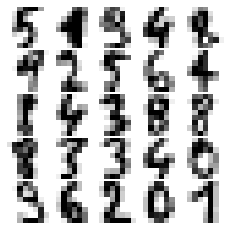

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# 머신러닝 라이브러리 import

digits = load_digits() 
#print(digits.keys())
print(digits.data.shape)
j = 1
np.random.seed(1)
fig = plt.figure(figsize=(3,3)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
for i in np.random.choice(digits.data.shape[0], 25):
    plt.subplot(5,5,j), plt.imshow(np.reshape(digits.data[i,:], (8,8)), cmap='binary'), plt.axis('off')
    j += 1
plt.show()
# digits 데이터 셋 로드
# 데이터 shape 출력
# 이미지 데이터 반복문으로 출력

0.28509364823697003


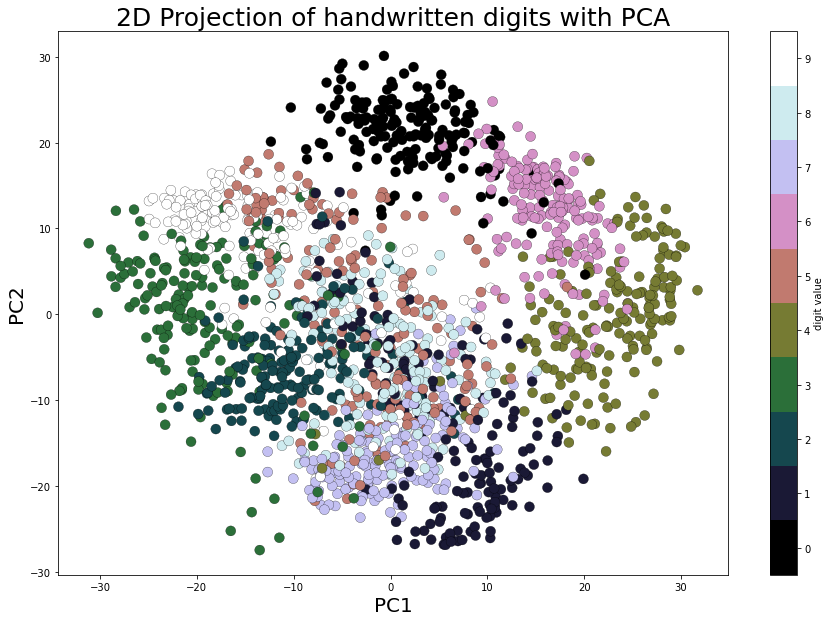

In [3]:
pca_digits=PCA(2)
digits.data_proj = pca_digits.fit_transform(digits.data) 
print(np.sum(pca_digits.explained_variance_ratio_))
plt.figure(figsize=(15,10))
plt.scatter(digits.data_proj[:, 0], digits.data_proj[:, 1], lw=0.25, c=digits.target, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
plt.xlabel('PC1', size=20), plt.ylabel('PC2', size=20), plt.title('2D Projection of handwritten digits with PCA', size=25)
plt.colorbar(ticks=range(10), label='digit value')
plt.clim(-0.5, 9.5)

# PCA 활용 digits data 특징값 2D 이미지로 출력

### Eigenfaces with PCA

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\cau\scikit_learn_data
(400, 4096)


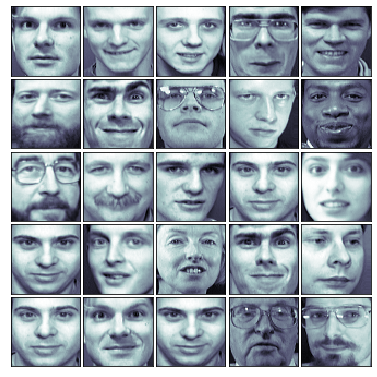

In [4]:
from sklearn.datasets import fetch_olivetti_faces 
faces = fetch_olivetti_faces().data
print(faces.shape) # there are 400 faces each of them is of 64x64=4096 pixels
fig = plt.figure(figsize=(5,5)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot 25 random faces
j = 1
np.random.seed(0)
for i in np.random.choice(range(faces.shape[0]), 25): 
    ax = fig.add_subplot(5, 5, j, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(faces[i,:],(64,64)), cmap=plt.cm.bone, interpolation='nearest') 
    j += 1
plt.show()
# faces 데이터 셋 로드
# 데이터 shape 출력
# 이미지 데이터 반복문으로 출력

(400, 64)


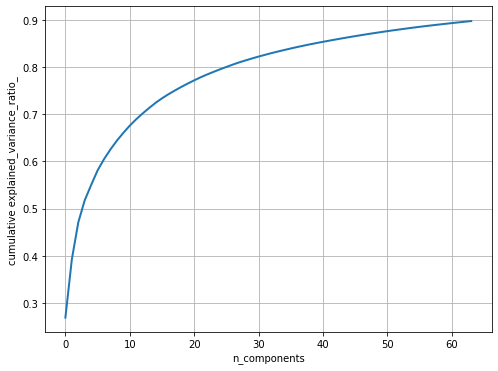

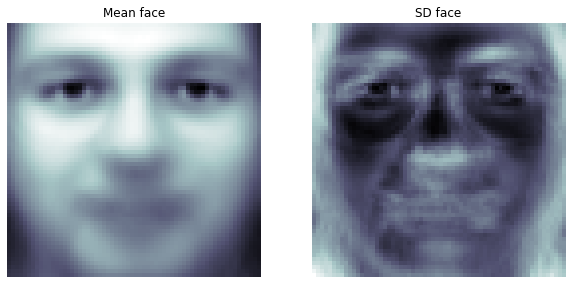

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
n_comp =64
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_comp))])
faces_proj = pipeline.fit_transform(faces)
print(faces_proj.shape)
# (400, 64)
mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, (64,64))
sd_face = np.reshape(np.sqrt(pipeline.named_steps['scaling'].var_), (64,64))
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pipeline.named_steps['pca'].explained_variance_ratio_), linewidth=2)
plt.grid(), plt.axis('tight'), plt.xlabel('n_components'), plt.ylabel('cumulative explained_variance_ratio_')
plt.show(), plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(mean_face, cmap=plt.cm.bone), plt.axis('off'), plt.title('Mean face')
plt.subplot(122), plt.imshow(sd_face, cmap=plt.cm.bone), plt.axis('off'), plt.title('SD face')
plt.show()

# 주성분 64개를 선택
# standardscaler 실시
# 표준 얼굴과 평균 얼굴 값 저장

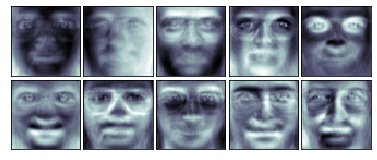

In [6]:
fig = plt.figure(figsize=(5,2)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the first 10 eigenfaces
for i in range(10): 
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(pipeline.named_steps['pca'].components_[i,:], (64,64)), cmap=plt.cm.bone, interpolation='nearest')
    
# 웨엇 생성한 이미지 10개 출력

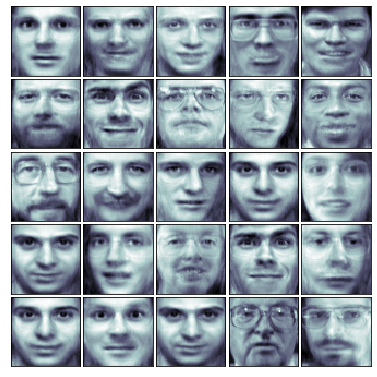

In [7]:
# face reconstruction
faces_inv_proj = pipeline.named_steps['pca'].inverse_transform(faces_proj) 
#reshaping as 400 images of 64x64 dimension 
fig = plt.figure(figsize=(5,5)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the faces, each image is 64 by 64 dimension but 8x8 pixels 
j = 1
np.random.seed(0)
for i in np.random.choice(range(faces.shape[0]), 25): 
    ax = fig.add_subplot(5, 5, j, xticks=[], yticks=[]) 
    ax.imshow(mean_face + sd_face*np.reshape(faces_inv_proj,(400,64,64)) [i,:], cmap=plt.cm.bone, interpolation='nearest')
    j += 1
    
# PCA face 이미지 출력

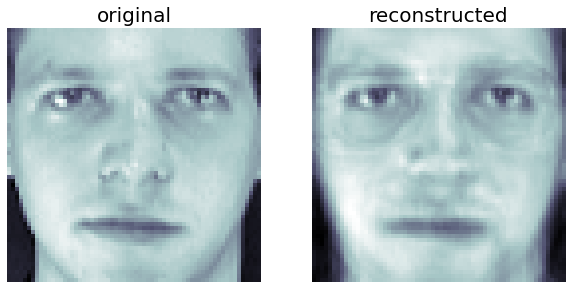

In [8]:
#print(faces_proj[0,:].shape)
#print(pipeline.named_steps['pca'].components_.shape)
orig_face = np.reshape(faces[0,:], (64,64))
reconst_face = np.reshape(faces_proj[0,:]@pipeline.named_steps['pca'].components_, (64,64))
reconst_face = mean_face + sd_face*reconst_face
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(orig_face, cmap=plt.cm.bone, interpolation='nearest'), plt.axis('off'), plt.title('original', size=20)
plt.subplot(122), plt.imshow(reconst_face, cmap=plt.cm.bone, interpolation='nearest'), plt.axis('off'), plt.title('reconstructed', size=20)
plt.show()

# 이미지 출력

### K-means clustering for image segmentation with color quantization

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float
from time import time

pepper = imread("../images/pepper.jpg")

# Display the original image
plt.figure(1), plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off'), plt.title('Original image (%d colors)' %(len(np.unique(pepper)))), plt.imshow(pepper)
# papper 이미지 로드 및 출력

FileNotFoundError: No such file: 'c:\Users\cau\Desktop\군 특화 AI 자료\강의자료\기본과정\영상처리기초\images\pepper.jpg'

done in 0.209s.
Predicting color indices on the full image (k-means)
done in 0.020s.
done in 0.166s.
Predicting color indices on the full image (k-means)
done in 0.016s.
done in 0.104s.
Predicting color indices on the full image (k-means)
done in 0.017s.
done in 0.060s.
Predicting color indices on the full image (k-means)
done in 0.017s.


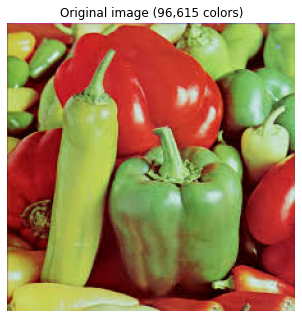

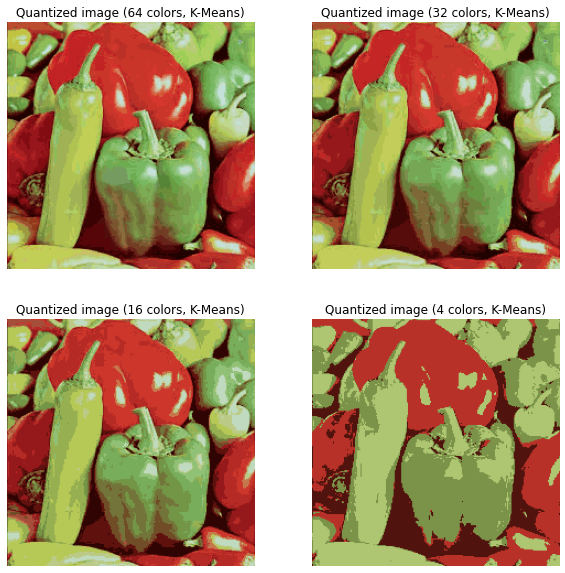

Predicting color indices on the full image (random)
done in 0.026s.
Predicting color indices on the full image (random)
done in 0.014s.
Predicting color indices on the full image (random)
done in 0.008s.
Predicting color indices on the full image (random)
done in 0.005s.


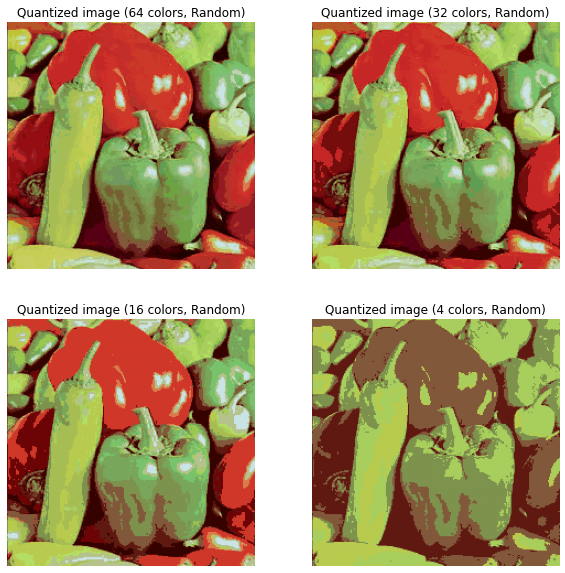

In [9]:
n_colors = 64

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
pepper = np.array(pepper, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(pepper.shape)
assert d == 3
image_array = np.reshape(pepper, (w * h, d))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(pepper)

plt.figure(2, figsize=(10,10))
plt.clf()
i = 1
for k in [64, 32, 16, 4]:
    t0 = time()
    plt.subplot(2,2,i)
    plt.axis('off')
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=k, random_state=0).fit(image_array_sample)
    print("done in %0.3fs." % (time() - t0))
    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    t0 = time()
    labels = kmeans.predict(image_array)
    print("done in %0.3fs." % (time() - t0))
    plt.title('Quantized image (' + str(k) + ' colors, K-Means)')
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
    i += 1
plt.show()

        
plt.figure(3, figsize=(10,10))
plt.clf()
i = 1
for k in [64, 32, 16, 4]:
    t0 = time()
    plt.subplot(2,2,i)
    plt.axis('off')
    codebook_random = shuffle(image_array, random_state=0)[:k + 1]
    print("Predicting color indices on the full image (random)")
    t0 = time()
    labels_random = pairwise_distances_argmin(codebook_random,
                                              image_array,
                                              axis=0)
    print("done in %0.3fs." % (time() - t0))    
    plt.title('Quantized image (' + str(k) + ' colors, Random)')
    plt.imshow(recreate_image(codebook_random, labels_random, w, h))
    i += 1
plt.show()

### Spectral clustering for image segmentation

C:\Users\windo\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\windo\anaconda3\envs\p37\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "
C:\Users\windo\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'contours'
C:\Users\windo\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not 

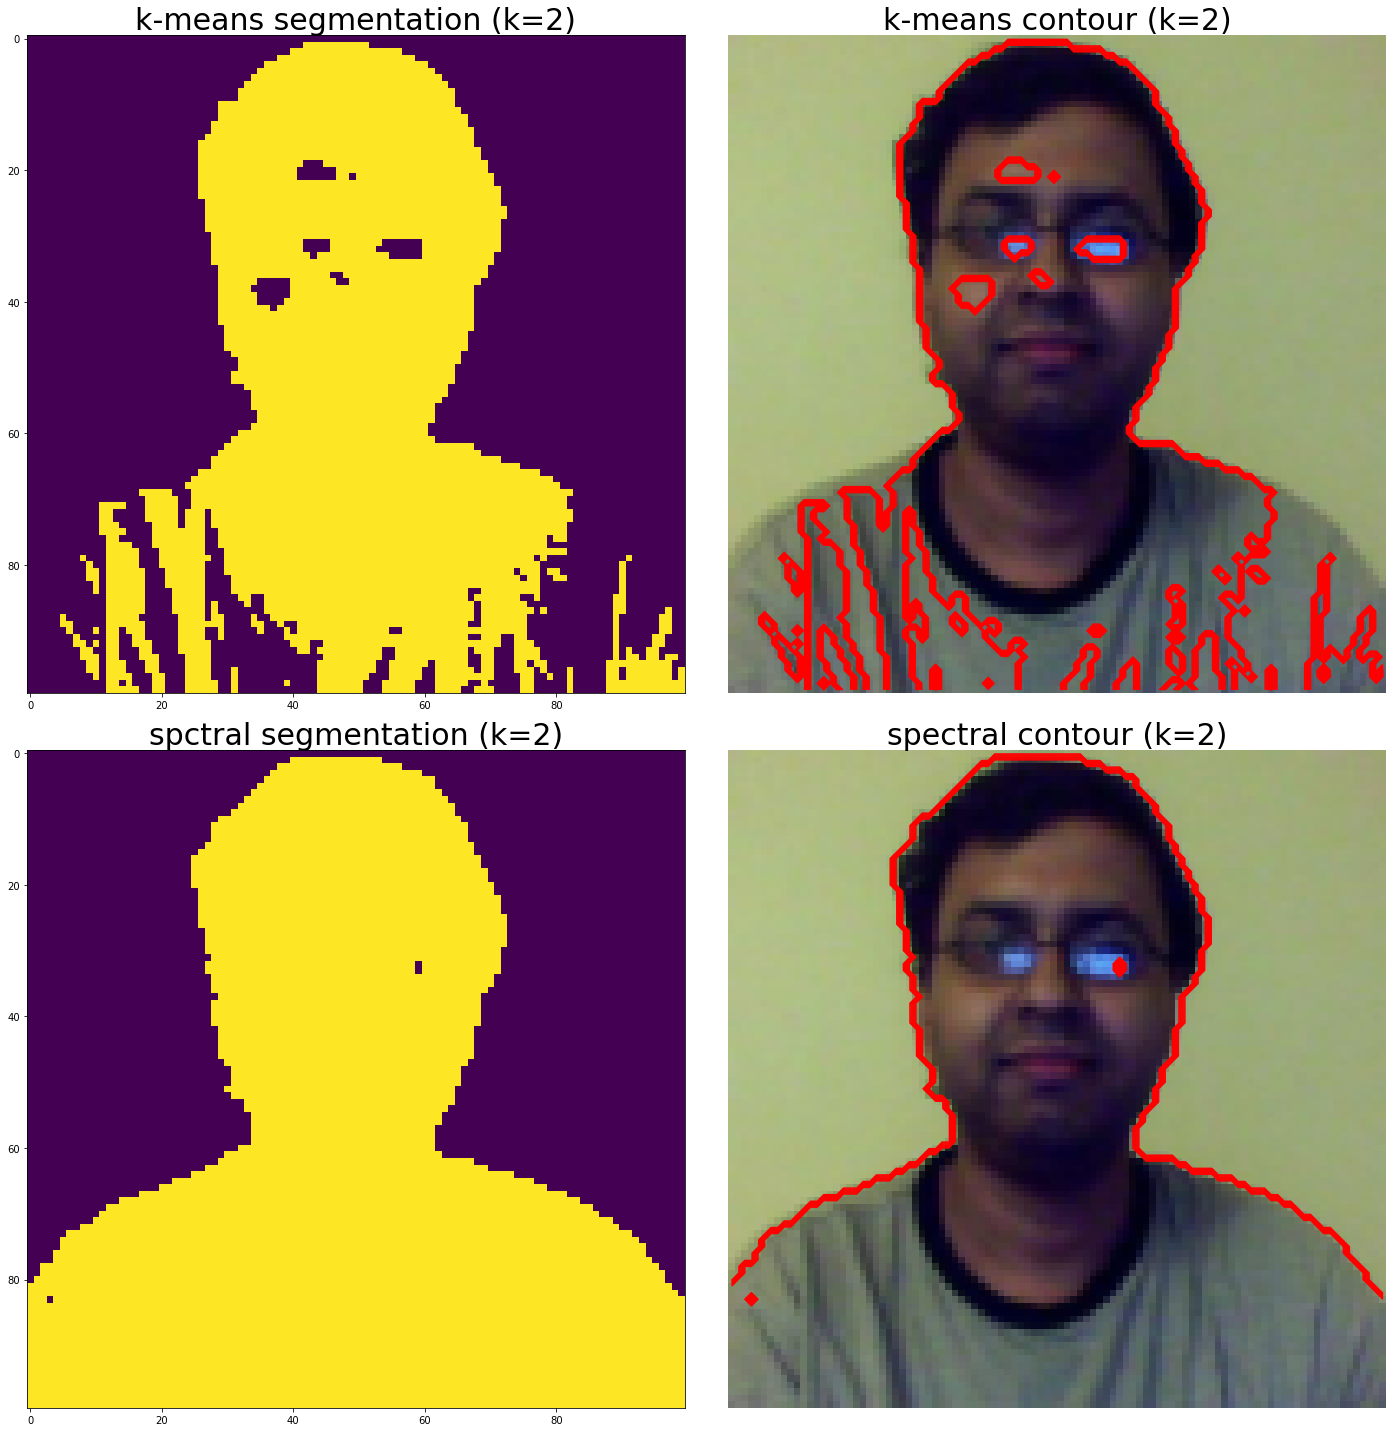

In [10]:
from sklearn import cluster
from skimage.io import imread
from skimage.color import rgb2gray
# from scipy.misc import imresize
# import matplotlib.pylab as pylab
from PIL import Image

# im = Image.resize(imread('../images/me14.jpg'), (100,100,3))
im_in = Image.open('../images/me14.jpg')
im_res = im_in.resize((100,100), Image.BILINEAR)
im = np.array(im_res)
img = rgb2gray(im)
k = 2 # binary segmentation, with 2 output clusters / segments
X = np.reshape(im, (-1, im.shape[-1]))
two_means = cluster.MiniBatchKMeans(n_clusters=k, random_state=10)
two_means.fit(X)
y_pred = two_means.predict(X)
labels = np.reshape(y_pred, im.shape[:2])
plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(np.reshape(y_pred, im.shape[:2])), plt.title('k-means segmentation (k=2)', size=30)
plt.subplot(222), plt.imshow(im), plt.contour(labels == 0, contours=1, colors='red'), plt.axis('off')
plt.title('k-means contour (k=2)', size=30)
spectral = cluster.SpectralClustering(n_clusters=k, eigen_solver='arpack', affinity="nearest_neighbors", n_neighbors=100, random_state=10)
spectral.fit(X) 
y_pred = spectral.labels_.astype(np.int)
labels = np.reshape(y_pred, im.shape[:2])
plt.subplot(223), plt.imshow(np.reshape(y_pred, im.shape[:2])), plt.title('spctral segmentation (k=2)', size=30)
plt.subplot(224), plt.imshow(im), plt.contour(labels == 0, contours=1, colors='red'), plt.axis('off'), plt.title('spectral contour (k=2)', size=30), plt.tight_layout()
plt.show()

### Classifying MNIST with k-nearest neighbors (KNN) classifier

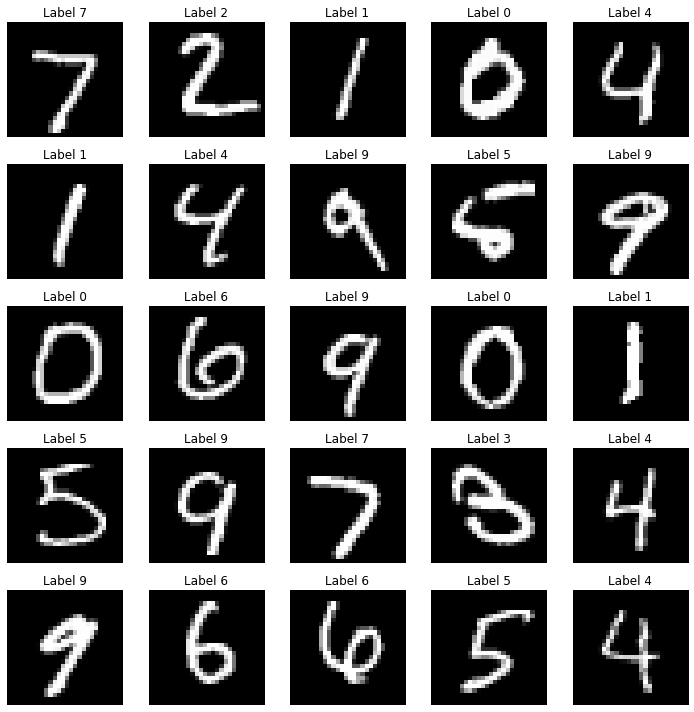

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve
    
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)
    # mnist 다운 함수 정의

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data
# 파일 존재유무 확인, data 784 1d로 reshape, data 리턴

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data
# 파일 존재유무 확인, data 리턴

## Load the training set
#path = 'C:\Courses\Edx\Current\USCD ML\Week3\\'
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')
# data, label 로드

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
# data, label 로드

## Define a function that displays a digit given its vector representation
def show_digit(x, label):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.title('Label ' + str(label))
    #plt.show()
    #return
    # digit 이미지 출력

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        label = train_labels[index]
        show_digit(train_data[index,], label)
    else:
        label = test_labels[index]
        show_digit(test_data[index,], label)
    #print("Label " + str(label))
    plt.show()
    return

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    #show_digit(train_data[i,], train_labels[i])
    show_digit(test_data[i,], test_labels[i])
plt.tight_layout()
plt.show()
# 이미지 출력

Time to build data structure (seconds):  4.724382400512695
t_before:  1661580210.3112347
t_after:  1661580706.5082889
Time to classify test set (seconds):  496.19705414772034


<AxesSubplot:>

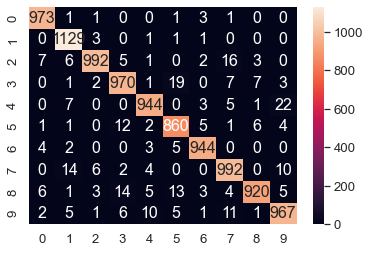

In [13]:
import time
from sklearn.neighbors import BallTree
## Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()
## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)
## Get nearest neighbor predictions on testing data
t_before = time.time()
print('t_before: ', t_before)
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
test_predictions = train_labels[test_neighbors]
t_after = time.time()
print('t_after: ', t_after)

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)
# evaluate the classifier
t_accuracy = sum(test_predictions == test_labels) / float(len(test_labels))
t_accuracy
# 0.96909999999999996
import pandas as pd
import seaborn as sn
from sklearn import metrics
cm = metrics.confusion_matrix(test_labels,test_predictions)
df_cm = pd.DataFrame(cm, range(10), range(10))
sn.set(font_scale=1.2)# for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")

# 작업 공정별 수행 시간을 구하고,
# test 데이터에 대한 예측 결과를 혼동행렬로 출력

### Classifying MNIST with Bayes classifier (Gaussian generative model)

In [14]:
def display_char(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    c = 3500 #10000 #1000 #100 #10 #0.1 #1e9
    for label in range(k):
        indices = (y == label)
        pi[label] = sum(indices) / float(len(y))
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1) + c*np.eye(d)
    return mu, sigma, pi

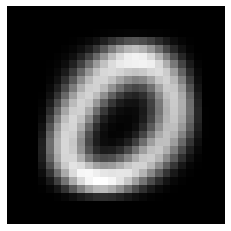

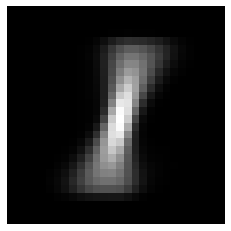

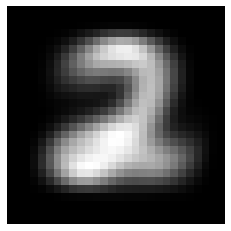

In [15]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
display_char(mu[0])
display_char(mu[1])
display_char(mu[2])

In [16]:
# Compute log Pr(label|image) for each [test image,label] pair.
k = 10
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
test_predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(test_predictions != test_labels)
print("The generative model makes " + str(errors) + " errors out of 10000")
t_accuracy = sum(test_predictions == test_labels) / float(len(test_labels))
t_accuracy

The generative model makes 438 errors out of 10000


0.9562

In [17]:
print(train_data.shape)
print(test_data.shape)

(60000, 784)
(10000, 784)


### Claasfying MNIST with SVM classifier

In [18]:
from sklearn.svm import SVC
C = 1
#for C in [.01,.1,1.,10.,100.]:
clf = SVC(C=C, kernel='poly', degree=2)
clf.fit(train_data,train_labels)
print(C, clf.score(test_data,test_labels))

1 0.9774


In [1]:
import pandas as pd
import seaborn as sn
from sklearn import metrics
test_predictions = clf.predict(test_data)
cm=metrics.confusion_matrix(test_labels,test_predictions)
df_cm = pd.DataFrame(cm, range(10), range(10))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g") #, cmap='viridis')# font size

NameError: name 'clf' is not defined

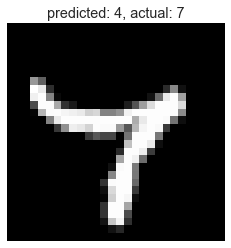

In [20]:
wrong_indices = test_predictions != test_labels

wrong_digits, wrong_preds, correct_labs = test_data[wrong_indices], test_predictions[wrong_indices], test_labels[wrong_indices]

plt.title('predicted: ' + str(wrong_preds[1]) + ', actual: ' + str(correct_labs[1]))
display_char(wrong_digits[1])

### Finding the most important Haar-like features for face classification with the random forest ensemble classifier

In [21]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from dask import delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

images = lfw_subset()
print(images.shape)

(200, 25, 25)


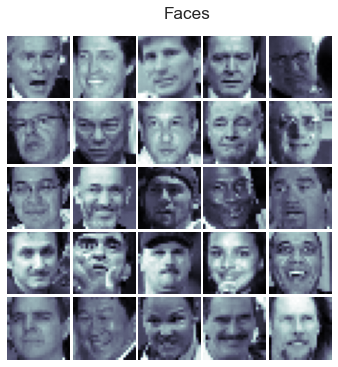

In [22]:
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=0.9, hspace=0.05, wspace=0.05) 
for i in range(25):
    plt.subplot(5,5,i+1), plt.imshow(images[i,:,:], cmap='bone'), plt.axis('off')
plt.suptitle('Faces')
plt.show()

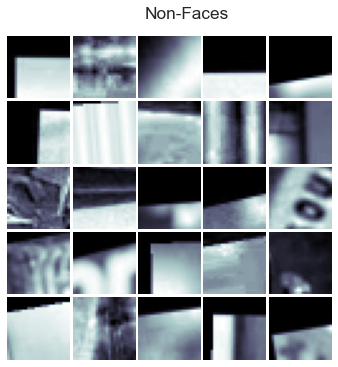

In [23]:
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=0.9, hspace=0.05, wspace=0.05) 
for i in range(100,125):
    plt.subplot(5,5,i-99), plt.imshow(images[i,:,:], cmap='bone'), plt.axis('off')
plt.suptitle('Non-Faces')
plt.show()

In [24]:
# For speed, only extract the two first types of features
feature_types = ['type-2-x', 'type-2-y']

# Build a computation graph using dask. This allows using multiple CPUs for
# the computation step
X = delayed(extract_feature_image(img, feature_types)
            for img in images)
# Compute the result using the "processes" dask backend
t_start = time()
X = np.array(X.compute(scheduler='processes'))
time_full_feature_comp = time() - t_start
y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)
print(time_full_feature_comp)
print(X.shape, X_train.shape, y_train.shape)

10.124957084655762
(200, 101400) (150, 101400) (150,)


In [25]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Extract all possible features to be able to select the most salient.
feature_coord, feature_type = \
        haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                                feature_type=feature_types)
    
# Train a random forest classifier and check performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(auc_full_features)

1.0


Text(0.5, 0.98, 'The most important features')

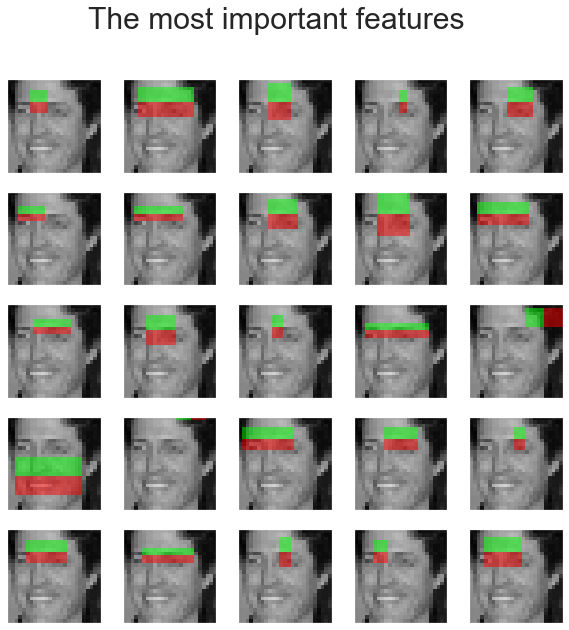

In [26]:
# Sort features in order of importance, plot six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(5, 5, figsize=(10,10))
for idx, ax in enumerate(axes.ravel()):
    image = images[1]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features', size=30)

### Detecting objects with SVM using HOG features 

367


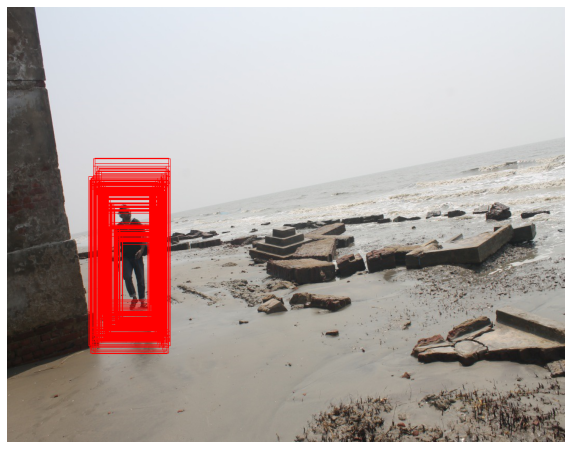

(<matplotlib.image.AxesImage at 0x26ec8f0fd48>,
 (-0.5, 1067.5, 711.5, -0.5),
 None)

In [27]:
import numpy as np
import cv2
import matplotlib.pylab as plt

# read in test image (from Microsoft COCO database)
img = cv2.imread("../images/me16.jpg")

# create HOG descriptor using default people (pedestrian) detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# run detection, using a spatial stride of 4 pixels (horizontal and verticle), a scale stride of 1.02, and zero grouping of
# rectangles (to demonstrate that HOG will detect at potentially multiple places in the scale pyramid)
#img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
#(foundBoundingBoxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=2, finalThreshold=0, useMeanshiftGrouping=True)
(foundBoundingBoxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.02, finalThreshold=0, useMeanshiftGrouping=False)

print(len(foundBoundingBoxes))
# we're going to copy the original test image to draw bounding boxes on it for now, as we'll use it again later
imgWithRawBboxes = img.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
        cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 1)
        
#plt.figure(figsize=(14, 10), dpi=80)
plt.figure(figsize=(10, 8))#, dpi=80)
imgWithRawBboxes = cv2.cvtColor(imgWithRawBboxes, cv2.COLOR_BGR2RGB)

plt.imshow(imgWithRawBboxes, aspect='auto'), plt.axis('off'), plt.show()

Before suppression, we had 367 bounding boxes, after suppression we have 1


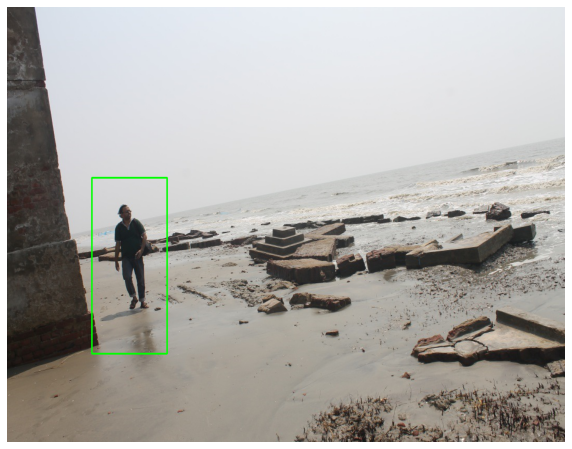

In [28]:
from imutils.object_detection import non_max_suppression

# convert our bounding boxes from format (x1, y1, w, h) to (x1, y1, x2, y2)
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in foundBoundingBoxes])

# run non-max suppression on these based on an overlay op 65%
nmsBoundingBoxes = non_max_suppression(rects, probs=None, overlapThresh=0.65)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(rects), len(nmsBoundingBoxes)))

# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(img, (xA, yA), (xB, yB), (0, 255, 0), 2)

# and show our work
plt.figure(figsize=(10, 8)) #, dpi=80)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, aspect='auto') 
plt.axis('off')
plt.show()